In [7]:
#To install the necessary packages, please run this cell:
!pip install -r pip_requirements.txt


In [3]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import math
import sys
from pathlib import Path
# import pyreadr
import seaborn as sns
# 


# I don't think we need these ^ since we import them in the other scripts 

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
#from src.data.clean_data import *
# I don't think we need this ^ either since we run it and don't use funciton from it later 
# from src.utils.data_utils import *
# from src.utils.plot_utils import *
# from src.models.lda_model import *

# we should really clean this up and only import the function we need

In [18]:
%run src/data/process_data.py
%run src/utils/data_utils.py
%run src/utils/plot_utils.py
%run src/models/lda_model.py

# why do we import and run the scripts ? 

[nltk_data] Downloading package stopwords to /Users/chsce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


IMPORTANT: these scripts/functions assume you have the following files in the data/raw directory:
- From the CMU dataset: 
    - movie.metadata.tsv
    - plot_summaries.txt
- From the TMDB dataset: 
    - TMDB_movie_dataset_v11.csv

AND have data/processed folder created

Note: download CMU dataset here: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
and TMDB dataset here (Download button): https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

In [1]:
# from raw files, creates clean datafiles
%run src/data/clean_data.py

Loading data from data/raw/TMDB_movie_dataset_v11.csv...
original df shape (1128267, 24)
after status (1102948, 24)
after adult (998193, 24)
after release date (669854, 24)
after release year (669854, 25)
after runtime (457010, 25)
after duplicates (453280, 25)
after numeric columns (453280, 25)
after string columns (453280, 25)
after production companies (453280, 25)
after select columns (453280, 13)
Loading data from data/raw/movie.metadata.tsv...
original df shape (81740, 9)
after release year (44006, 9)
after runtime (34490, 9)
after duplicates (34435, 9)
after numeric columns (34435, 9)
after string columns (34435, 9)
after select columns (34435, 5)
Loading data from data/raw/plot_summaries.txt...


In [4]:
# from clean data files, creates a dataframe with TMDB movies 
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.info()

You shoud have 361,971 entries in df

In [5]:
df.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate es...","[action, science fiction, adventure]","[legendary pictures, syncopy, warner bros. pic...","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,post
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who mak...,"[adventure, drama, science fiction]","[legendary pictures, syncopy, lynda obst produ...","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time...",2014,post
2,the dark knight,2008-07-16,1004558444,152,185000000,en,batman raises the stakes in his war on crime. ...,"[drama, action, crime, thriller]","[dc comics, legendary pictures, syncopy, isobe...","[united kingdom, united states of america]","[english, mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,post
3,avatar,2009-12-15,2923706026,162,237000000,en,"in the 22nd century, a paraplegic marine is di...","[action, adventure, fantasy, science fiction]","[dune entertainment, lightstorm entertainment,...","[united states of america, united kingdom]","[english, spanish]","[future, society, culture clash, space travel,...",2009,post
4,the avengers,2012-04-25,1518815515,143,220000000,en,when an unexpected enemy emerges and threatens...,"[science fiction, action, adventure]",[marvel studios],[united states of america],"[english, hindi, russian]","[new york city, superhero, shield, based on co...",2012,post


Our analysis centers on the effect DVDs on the movie industry. This question was motivated by an interview with actor Matt Damon, famous for his role in [Good Will Hunting](https://www.imdb.com/title/tt0119217/?ref_=ext_shr_lnk) and [the Martian](https://www.imdb.com/title/tt3659388/?ref_=ext_shr_lnk). 

In the interview with the [New York Times](https://www.nytimes.com/2021/07/27/magazine/matt-damon.html) , he claims that with the fall of DVDs, production companies lost a sizeable portion of their revenue and must rely almost entirely on box office revenues. The consequence of this, he claims, is that movies are now simpler and more international, to ensure broad appeal and better revenues at the box office:

"You know, because the DVD market dried up [...] that severely cut into the margins that studios would rather bet big on these big titles. And with this whole international audience, the more, you know, the simpler the story the more that it can kind of play, the less language matters so that the more broad appeal that it can play around the world, and that’s why you’re seeing the movies change."

With this in mind, we will analyze the effect of DVDs on the movie industry by looking at the following aspects:
- [DVD releases over time](#DVD-releases-over-time)
- [Revenue](#Revenue) 
- [Budget](#Budget)
- [Runtime](#Runtime)   
- [Genre](#Genre)
- [Production company](#Production-company)


To start our analysis we looked at DVD releases over time to properly define our eras. 


## DVD releases over time

In [23]:
# MOVE TO LOAD 
result = pyreadr.read_r('data/raw/movies.RData') 
df_dvd_releases = next(iter(result.values()))
df_dvd_releases['dvd_release_date'] = pd.to_datetime(
    df_dvd_releases[['dvd_rel_year', 'dvd_rel_month', 'dvd_rel_day']]
    .astype('Int64')
    .astype(str)
    .agg('-'.join, axis=1), 
    errors='coerce'
)
df_dvd_releases = df_dvd_releases.dropna(subset=['dvd_release_date'])
path = os.path.join('data', 'processed','dvd_releases.csv')
df_dvd_releases[['dvd_release_date']].to_csv(path, sep=',',
          index=False,
          header=True)

In [28]:
df_dvd_releases = load_raw_data('data/processed/dvd_releases.csv')
df_dvd_releases['dvd_release_date'] = pd.to_datetime(df_dvd_releases['dvd_release_date'])
df_grouped = df_dvd_releases.resample('M', on='dvd_release_date').size()


Loading data from data/processed/dvd_releases.csv...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dvd_release_date  643 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 5.1 KB


In [48]:
# Calculate our eras using our data
peak_date = df_grouped.idxmax()
peak_value = df_grouped.max()
mean_releases = df_grouped.mean()
std_releases = df_grouped.std()
threshold_low = mean_releases - std_releases
threshold_high = mean_releases + std_releases

pre_dvd_end = df_grouped[df_grouped > threshold_high].index[0]  # First time crosses upper threshold
post_dvd_start = df_grouped[df_grouped > threshold_high].index[-1]  # Last time crosses upper threshold
print(f"Pre-DVD Era: Before {pre_dvd_end.strftime('%Y')}")
print(f"DVD Era: {pre_dvd_end.strftime('%Y')} to {post_dvd_start.strftime('%Y')}")
print(f"Post-DVD Era: After {post_dvd_start.strftime('%Y')}")

Pre-DVD Era: Before 1997
DVD Era: 1997 to 2013
Post-DVD Era: After 2013


In [89]:
#MOVE TO PLOT UTILS
def style_plot(title='', xlabel='', ylabel='', legend=False):
    # plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.4)
    sns.despine()
    if legend:
        plt.legend()
    plt.show()

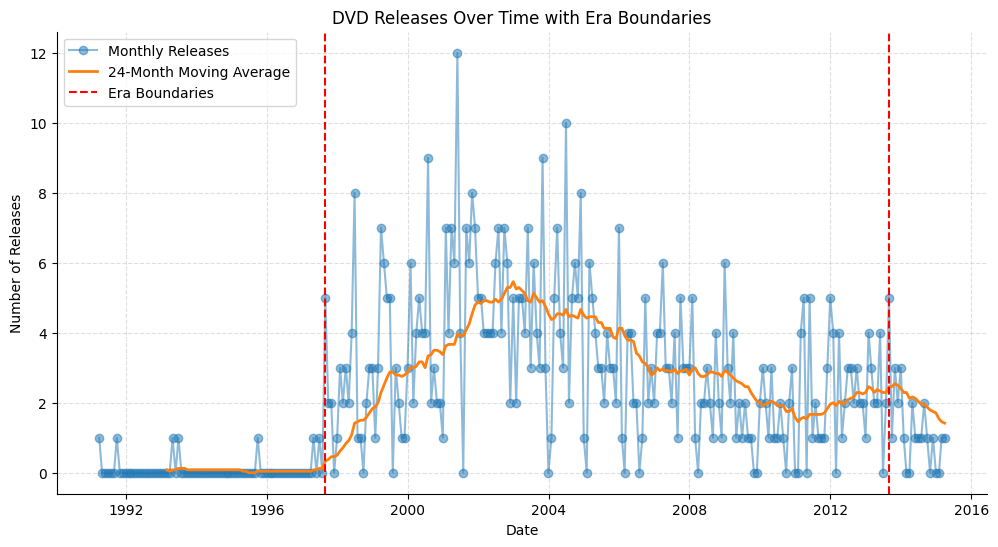

In [90]:
moving_avg = df_grouped.rolling(window=24).mean() 
plt.figure(figsize=(12, 6))

plt.plot(df_grouped.index, df_grouped.values, marker='o', alpha=0.5, label='Monthly Releases')
plt.plot(moving_avg.index, moving_avg.values, linewidth=2, label='24-Month Moving Average')

# Draw the era boundaries
plt.axvline(x=pre_dvd_end, color='r', linestyle='--', label='Era Boundaries')
plt.axvline(x=post_dvd_start, color='r', linestyle='--')

style_plot('DVD Releases Over Time with Era Boundaries', 'Date', 'Number of Releases', True)

## General Overview

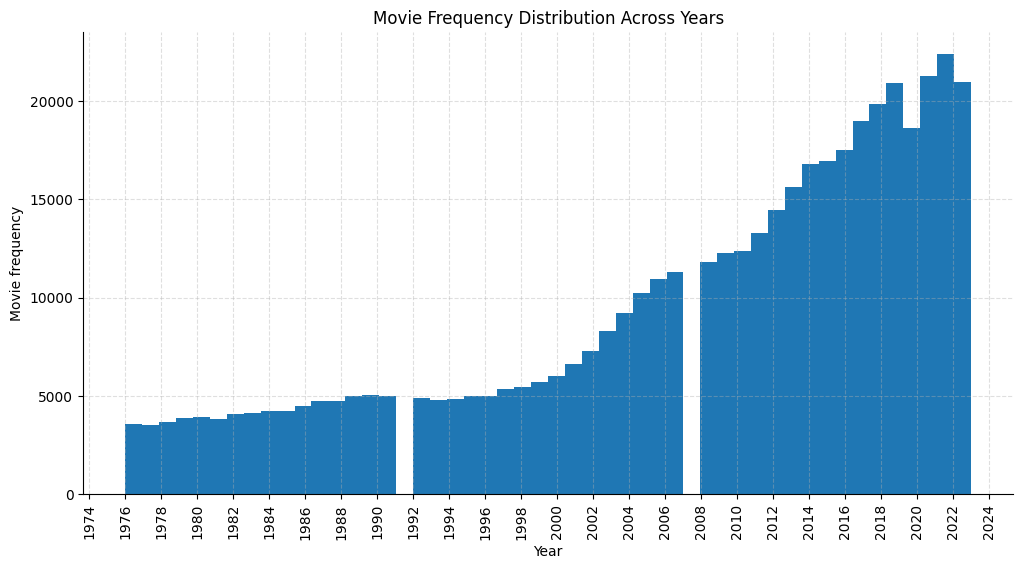

In [91]:
# Get a general distribution of movies
plt.figure(figsize=(12, 6))

plt.hist(df['release_year'], bins=50)
plt.locator_params(axis='x', nbins=50) 
plt.xticks(rotation=90)
style_plot('Movie Frequency Distribution Across Years', 'Year', 'Movie frequency')

## Revenue
We first want to get an overview of movie revenues

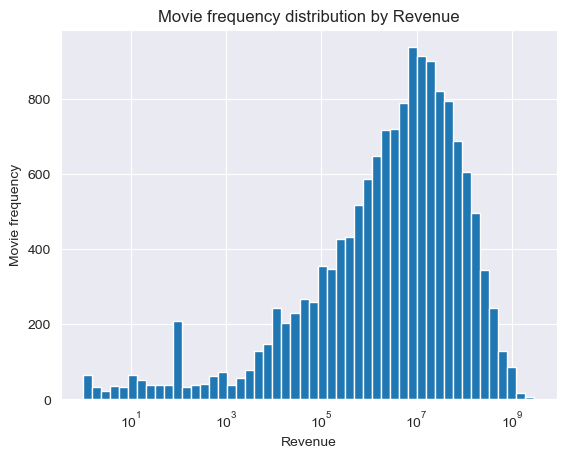

In [6]:
# Frequency distribution per budget, with budget in logscale 
plot_loghist(df[df['revenue'] > 0]['revenue'], 50, xlabel='Revenue', ylabel='Movie frequency')

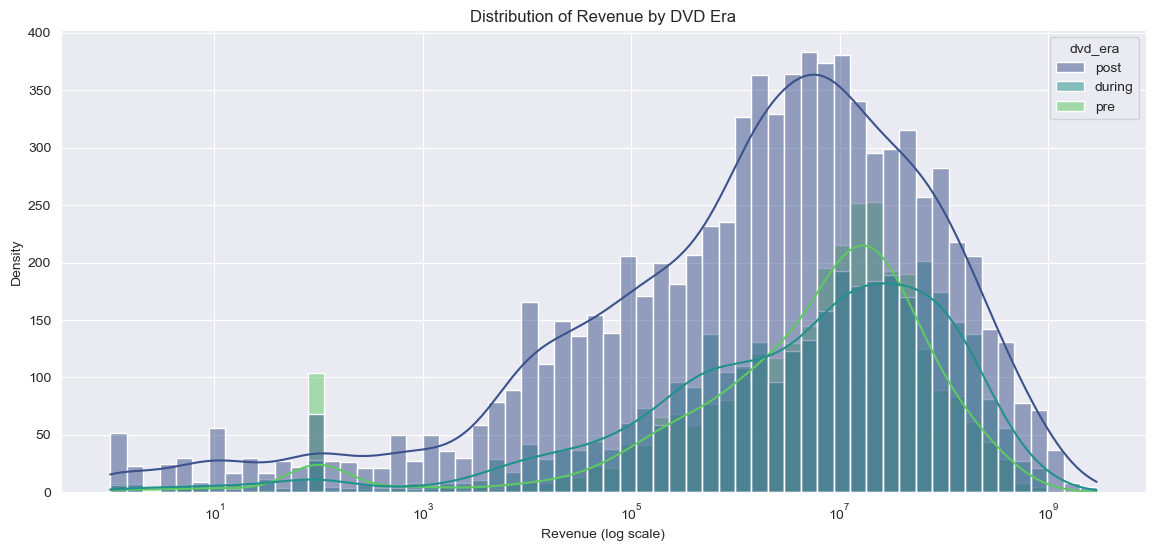

In [7]:
# Revenue per era
plot_revenue_per_era(df)

In [8]:
# Summary statistics for each DVD era
print('Summary statistics of revenue for each DVD era:')
df[df.revenue > 0].groupby('dvd_era')['revenue'].describe().reindex(['pre', 'during', 'post']).transpose()

Summary statistics of revenue for each DVD era:


dvd_era,pre,during,post
count,3.076000e+03,3.576000e+03,8.386000e+03
mean,3.272585e+07,5.088406e+07,4.996428e+07
std,7.217945e+07,1.160229e+08,1.539861e+08
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.222952e+06,5.630190e+05,1.516108e+05
50%,8.930740e+06,8.364978e+06,2.910307e+06
75%,2.921021e+07,4.821442e+07,2.488930e+07
max,9.201000e+08,2.264162e+09,2.923706e+09


# Budget overview
## Budget trends

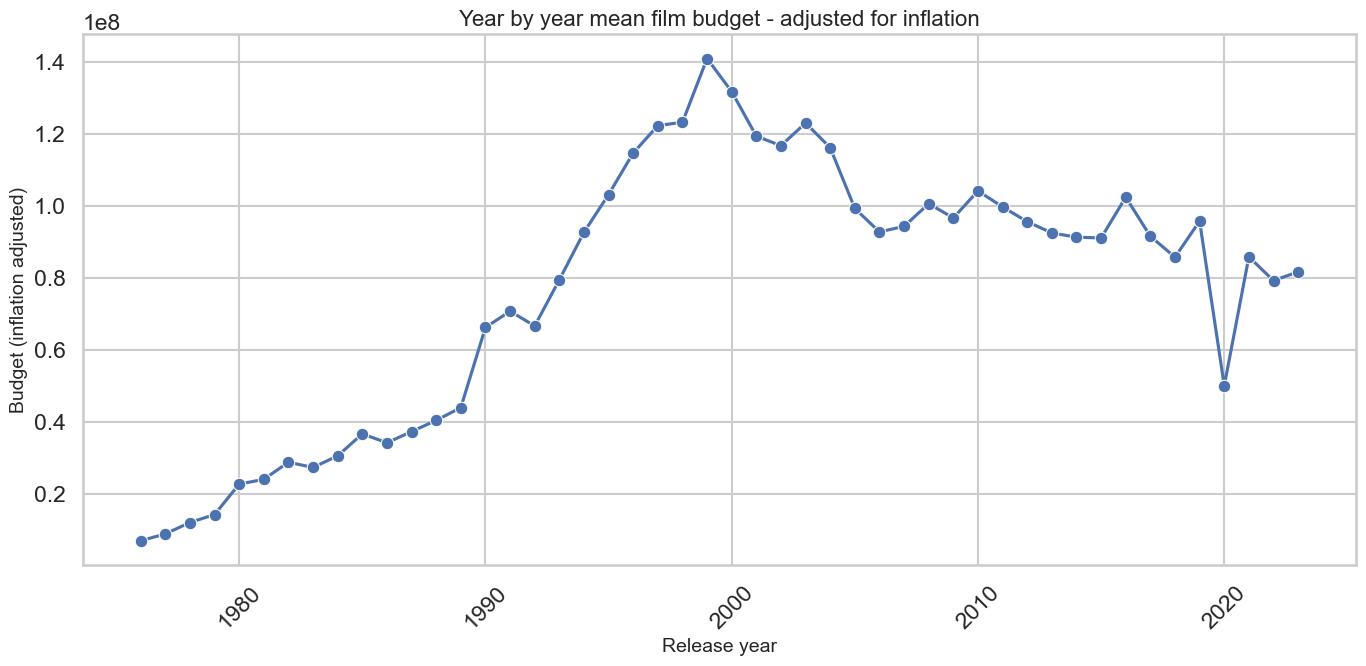

In [9]:
plot_mean_budget_inflation(df)

## Budget histograms

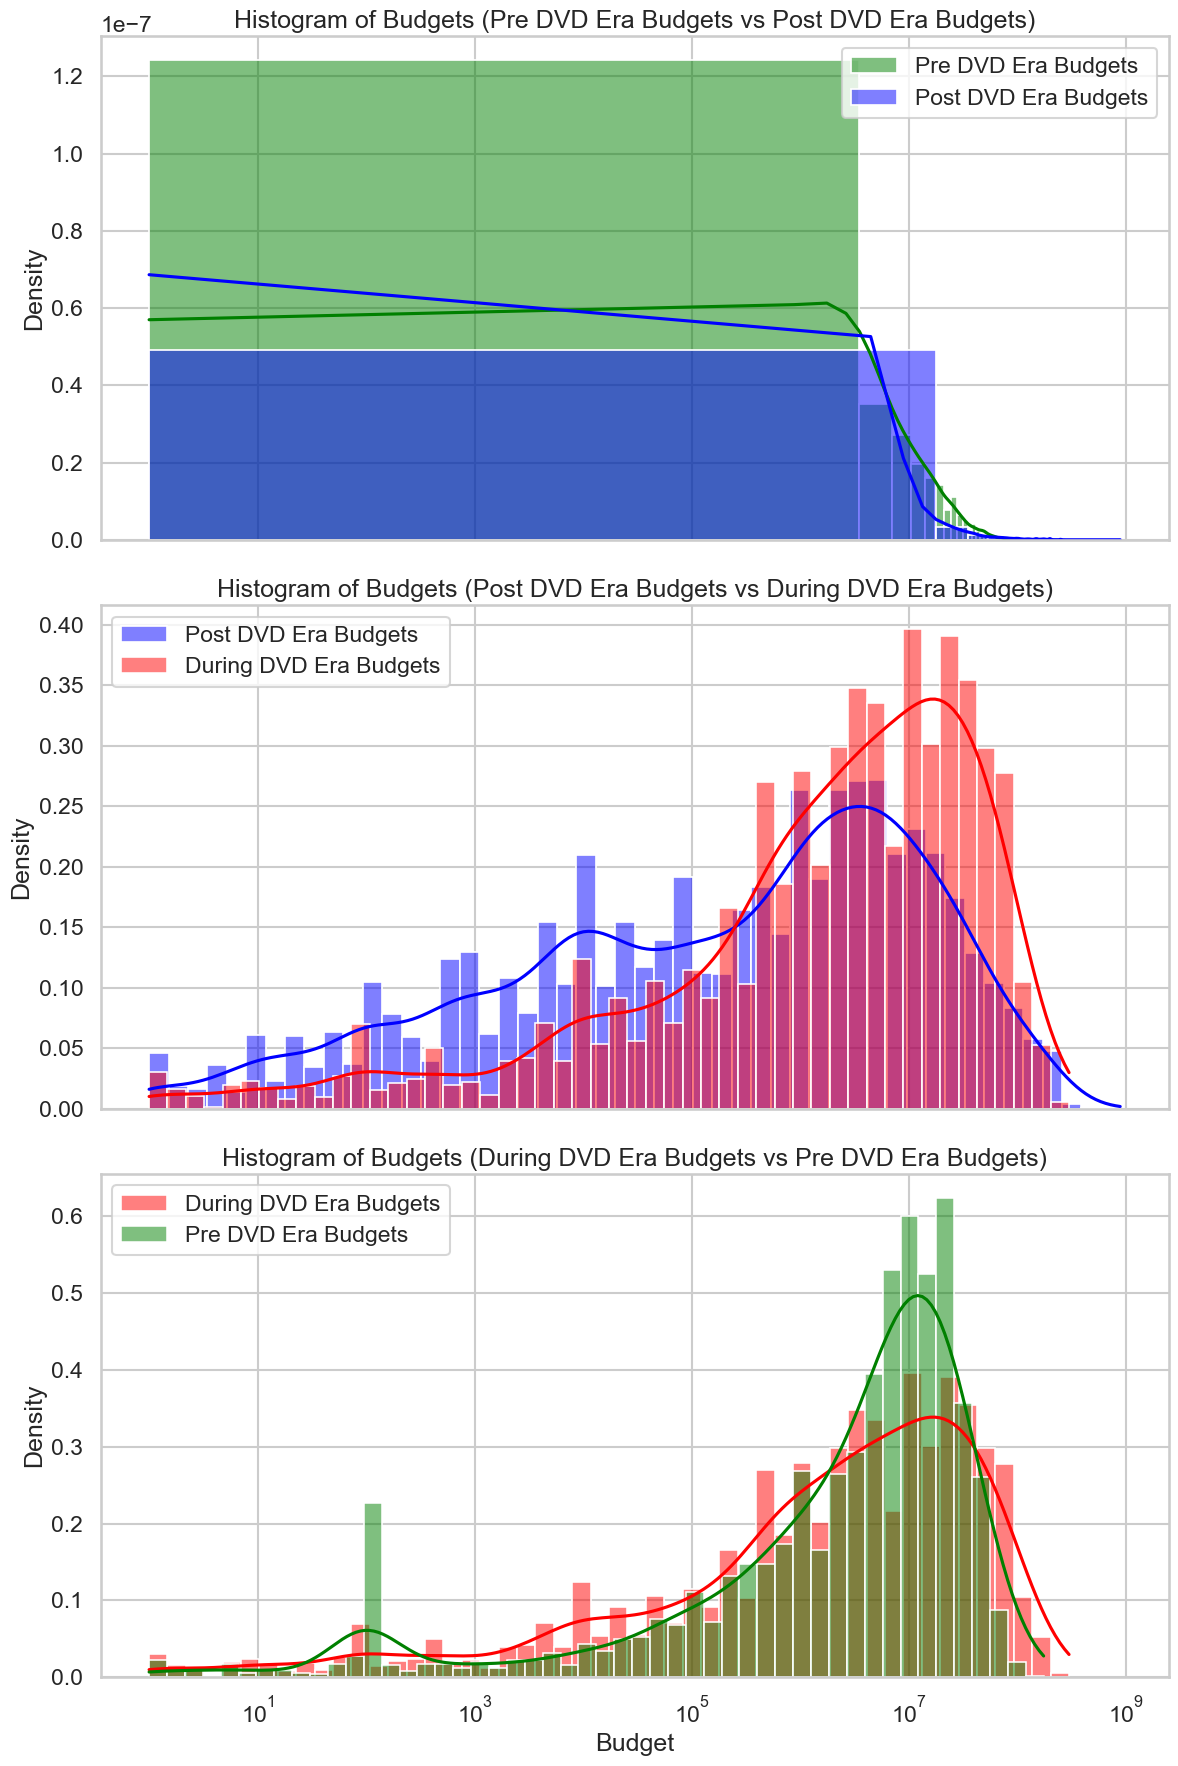

In [19]:
df_filtered = df[(df['budget'] > 0)]

# Define eras, colors, and labels for the plots
eras = [("pre", "post"), ("post", "during"), ("during", "pre")]
colors = [('green', 'blue'), ('blue', 'red'), ('red', 'green')]
labels = [('Pre DVD Era Budgets', 'Post DVD Era Budgets'), 
          ('Post DVD Era Budgets', 'During DVD Era Budgets'), 
          ('During DVD Era Budgets', 'Pre DVD Era Budgets')]

# Plot histograms
plot_budget_histograms(df_filtered, eras, colors, labels, 'Histogram of Budgets')

## Production types

/Users/chsce/Documents/ada-2024-project-databand/src/utils/data_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'budget_category'] = df.apply(categorize_budget, args=(budget_stats,), axis=1)


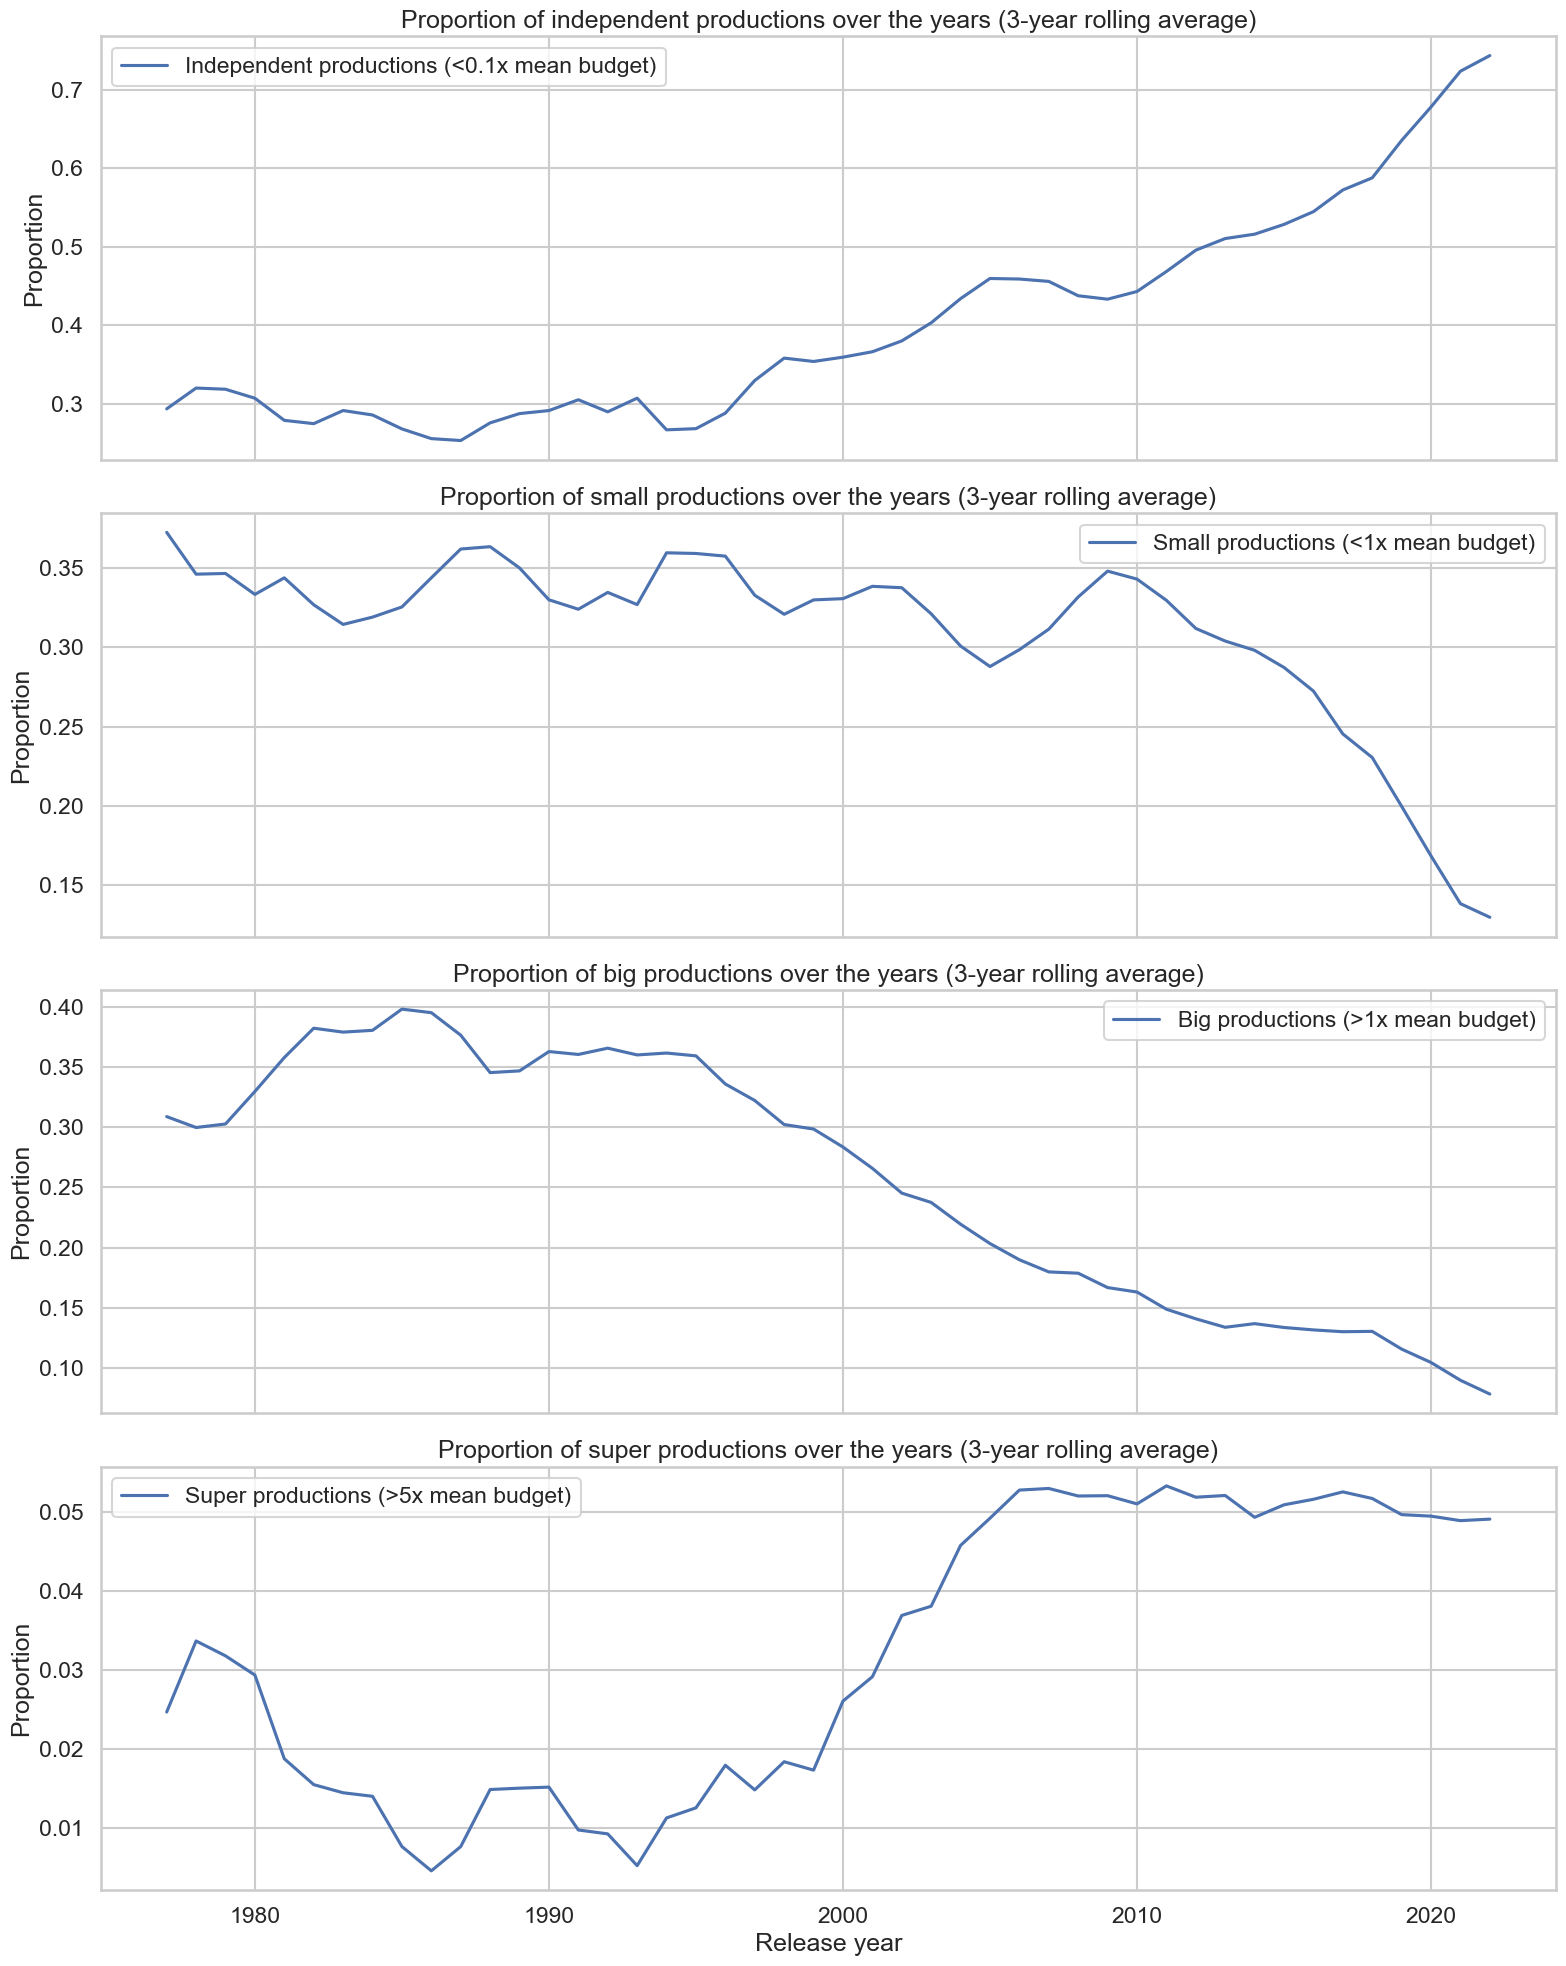

In [20]:
prop_rolling_avg = budget_rolling_averages(df_filtered, window=3)
plot_rolling_averages(prop_rolling_avg)

## Production Companies

In [94]:
df['production_companies'].str.len().value_counts().sort_index().head()


production_companies
0    230141
1    137370
2     46715
3     20909
4      8481
Name: count, dtype: int64

Notice, there are 230,141 with no production companies, we will make sure to exclude these for this part of the analysis 

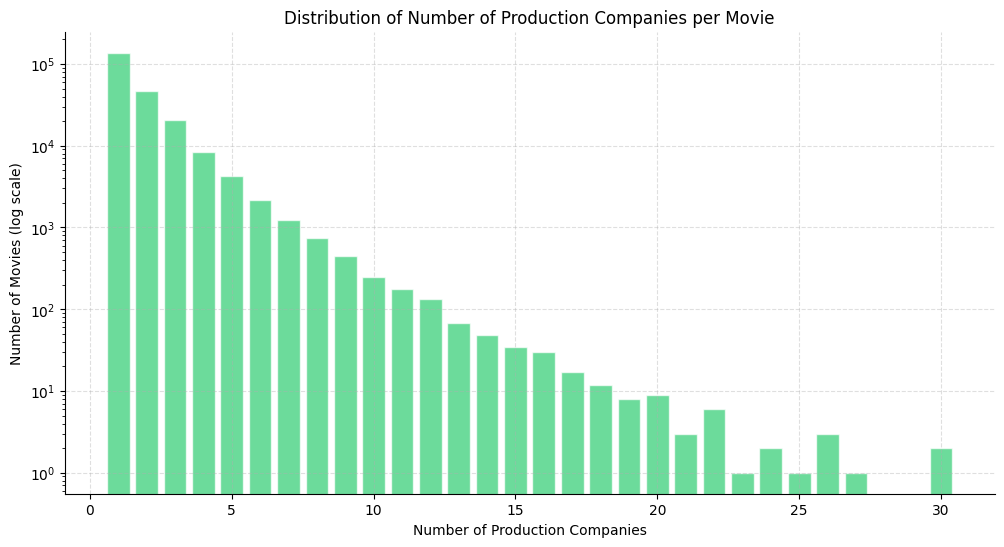

Movies with single production company: 137,370 (61.6%)
Movies with multiple production companies: 85,769 (38.4%)


In [97]:
company_counts = df['production_companies'].str.len().value_counts().sort_index()
company_counts = company_counts[company_counts.index > 0]
plt.figure(figsize=(12, 6))
plt.bar(company_counts.index, company_counts.values, color='#2ecc71', alpha=0.7, edgecolor='white')

plt.yscale('log')
style_plot('Distribution of Number of Production Companies per Movie', 'Number of Production Companies', 'Number of Movies (log scale)', False)

print(f"Movies with single production company: {company_counts.get(1, 0):,} ({company_counts.get(1, 0)/company_counts.sum()*100:.1f}%)")
print(f"Movies with multiple production companies: {company_counts[company_counts.index > 1].sum():,} ({company_counts[company_counts.index > 1].sum()/company_counts.sum()*100:.1f}%)")

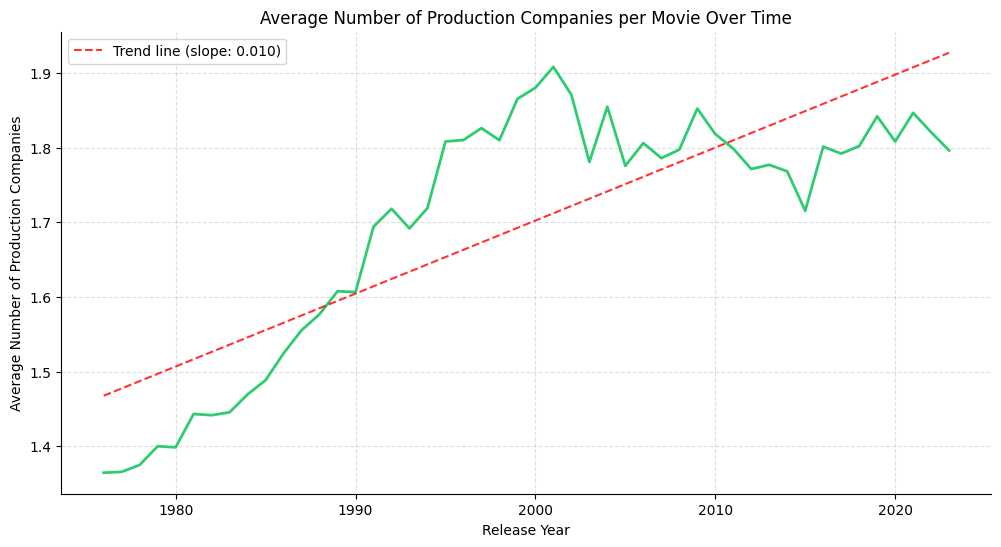

In [98]:
# df_prod = df[df['production_companies'].str.len() > 0]
plt.figure(figsize=(12, 6))

yearly_avg_companies = (df[df['production_companies'].str.len() > 0].groupby('release_year')
                       .agg({'production_companies': lambda x: x.str.len().mean()})
                       .reset_index())


plt.plot(yearly_avg_companies['release_year'], 
        yearly_avg_companies['production_companies'],
        linewidth=2,
        color='#2ecc71')

z = np.polyfit(yearly_avg_companies['release_year'], 
               yearly_avg_companies['production_companies'], 1)
p = np.poly1d(z)
plt.plot(yearly_avg_companies['release_year'], 
         p(yearly_avg_companies['release_year']), 
         "r--", 
         alpha=0.8,
         label=f'Trend line (slope: {z[0]:.3f})')

style_plot('Average Number of Production Companies per Movie Over Time', 'Release Year', 'Average Number of Production Companies', True)

Covariance between year and avg number of production companies: 1.915
Correlation between year and avg number of production companies: 0.820


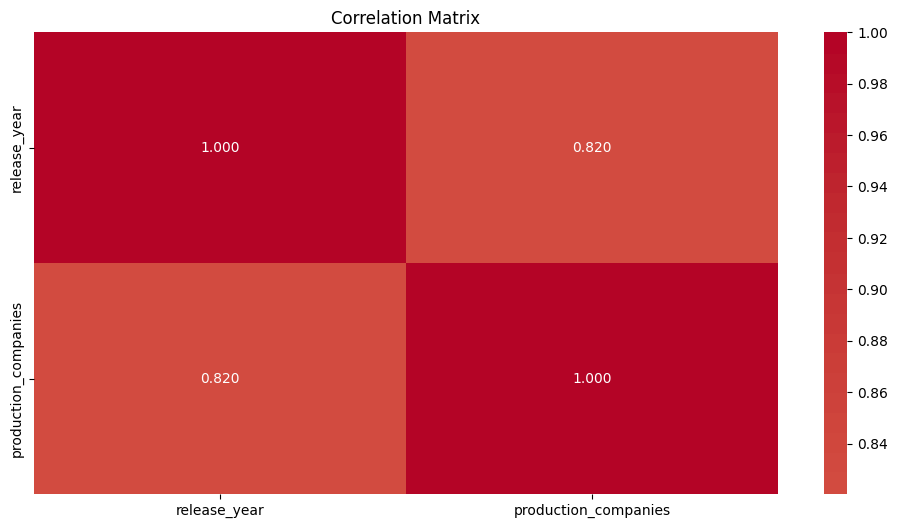

In [99]:
correlation = yearly_avg_companies['release_year'].corr(yearly_avg_companies['production_companies'])
covariance = yearly_avg_companies['release_year'].cov(yearly_avg_companies['production_companies'])

print(f"Covariance between year and avg number of production companies: {covariance:.3f}")
print(f"Correlation between year and avg number of production companies: {correlation:.3f}")

plt.figure(figsize=(12, 6))
sns.heatmap(yearly_avg_companies.corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

<Axes: >

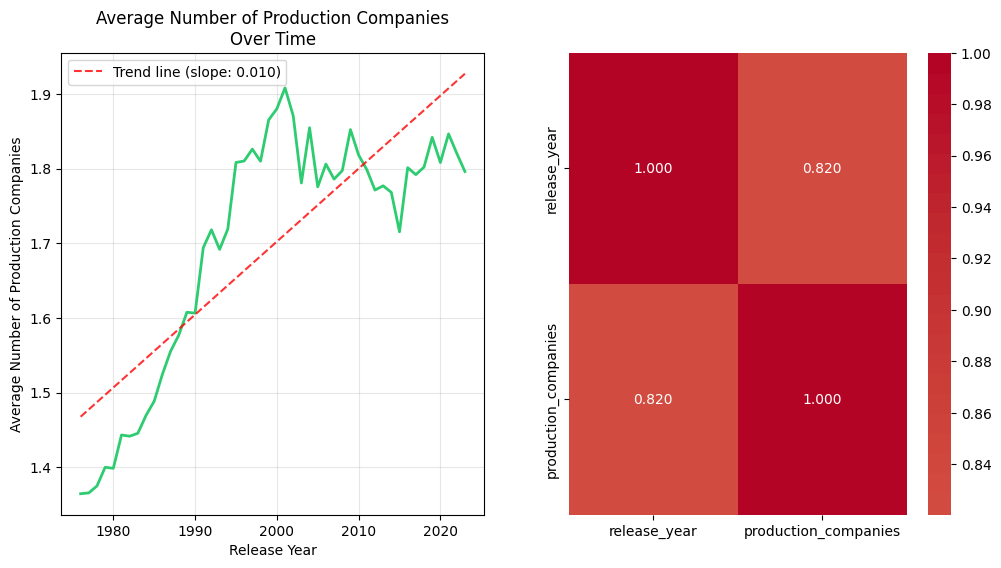

In [105]:
yearly_avg_companies = (df[df['production_companies'].str.len() > 0].groupby('release_year')
                       .agg({'production_companies': lambda x: x.str.len().mean()})
                       .reset_index())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(yearly_avg_companies['release_year'], 
             yearly_avg_companies['production_companies'],
             linewidth=2,
             color='#2ecc71')
z = np.polyfit(yearly_avg_companies['release_year'], 
               yearly_avg_companies['production_companies'], 1)
p = np.poly1d(z)
ax1.plot(yearly_avg_companies['release_year'], 
         p(yearly_avg_companies['release_year']), 
         "r--", 
         alpha=0.8,
             label=f'Trend line (slope: {z[0]:.3f})')

# style_plot('Average Number of Production Companies\nOver Time', 'Release Year', 'Average Number of Production Companies', True)
ax1.set_title('Average Number of Production Companies\nOver Time')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Average Number of Production Companies')
ax1.grid(True, alpha=0.3)
ax1.legend()
    
correlation = yearly_avg_companies['release_year'].corr(yearly_avg_companies['production_companies'])
covariance = yearly_avg_companies['release_year'].cov(yearly_avg_companies['production_companies'])

sns.heatmap(yearly_avg_companies.corr(), 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.3f',
                ax=ax2)
    


From this initial analysis, there is a strong correlation between the number of production companies per movie and the release year. 

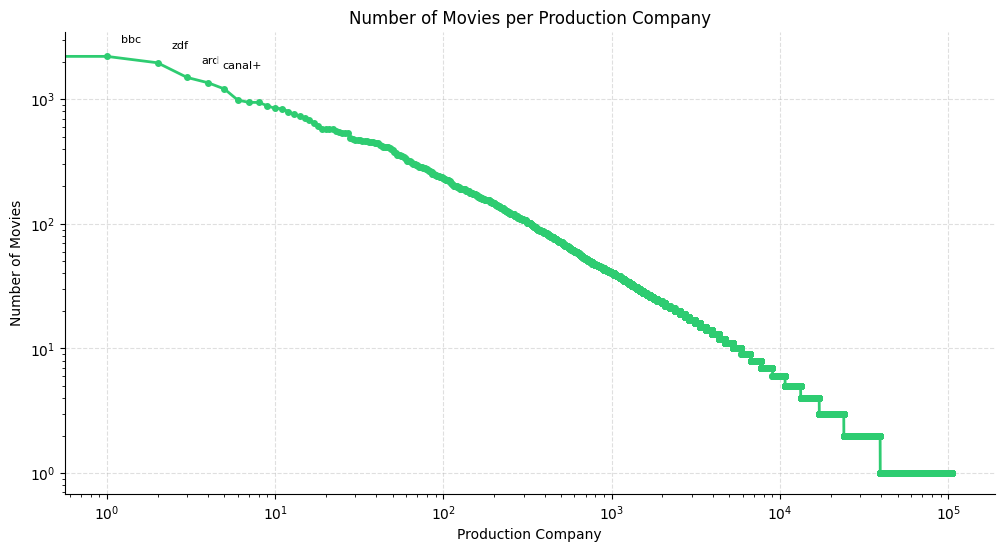

count    105699.000000
mean          3.692854
std          21.372540
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2344.000000
Name: count, dtype: float64


In [111]:
companies = df['production_companies'].explode().value_counts()
plt.figure(figsize=(12, 6))

plt.plot(range(len(companies)), 
         companies.values, 
         linewidth=2, 
         marker='o',
         markersize=4,
         color='#2ecc71')
plt.yscale('log')
plt.xscale('log')

for i in range(5):  # Annotate top 5
    plt.annotate(f'{companies.index[i]}',
                xy=(i, companies.values[i]),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
style_plot('Number of Movies per Production Company', 'Production Company', 'Number of Movies', False)

print(df['production_companies'].explode().value_counts().describe())

# Runtime overview


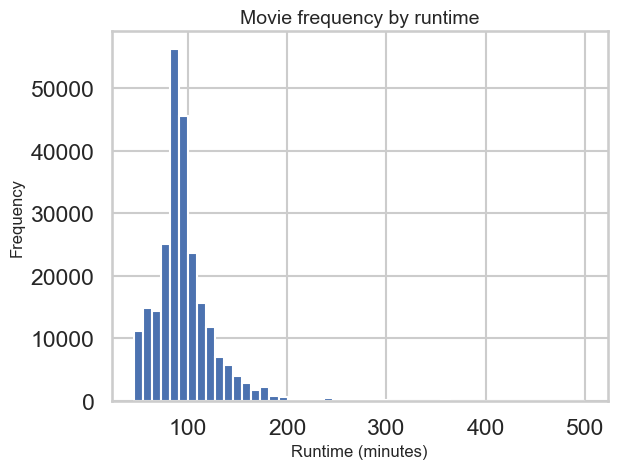

In [23]:
# General runtime distribution
plt.hist(df[(df['runtime'] > 0)]['runtime'], bins=50)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Movie frequency by runtime', fontsize=14)
plt.show()

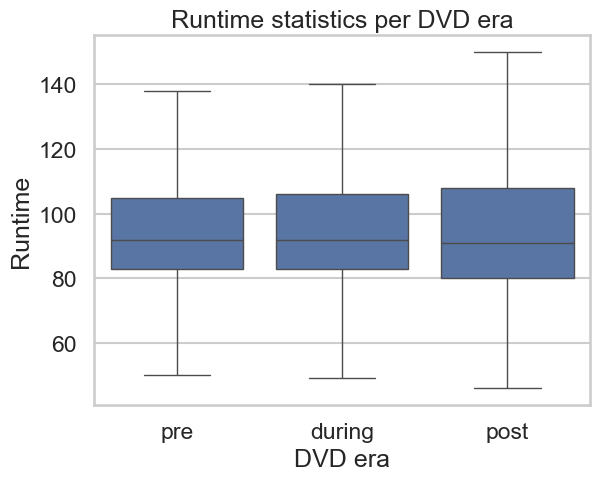

In [25]:
# Runtime statistics in boxplot 
sns.boxplot(x='dvd_era', y='runtime', data=df[df['runtime'] > 0], showfliers=False, order=['pre', 'during', 'post'])
plt.xlabel('DVD era')
plt.ylabel('Runtime')
plt.title('Runtime statistics per DVD era')
plt.show()

# Genre overview
For each DVD era, we obtain the top-10 movie genres based on the proportion of movies.


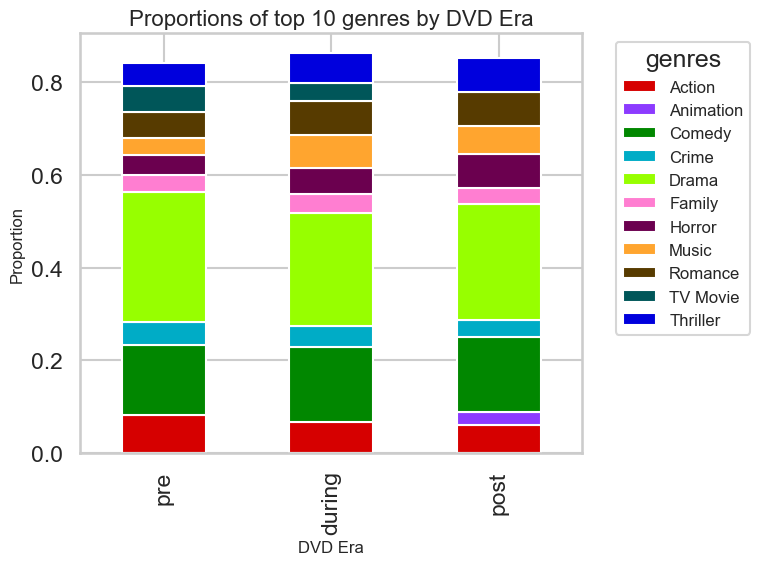

In [14]:
top_10_genre =top_proportions_per_era(df, 'genres', 10, True)
plot_top_proportions_per_era(top_10_genre, 'genres', 10)

# Theme extraction

For the major genres, we use LDA to extract the main topics in movies of the genre, with the goal of checking whether the main topics change overtime. Here is an example of topic extraction for the Drama movie genre, which appears to be the most common genre in the plot above. 

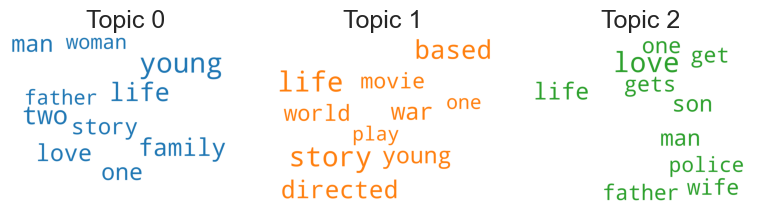

In [15]:
# Pre-process movie plots, lowercase, removing stopwords & special characters
df['clean_overview'] = df.overview.apply(clean_text)

# Extract plots for Drama genre and pre-DVD era
text_data = get_movie_plots(df, 'Drama', 'pre')
# Extract 3 main topics 
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

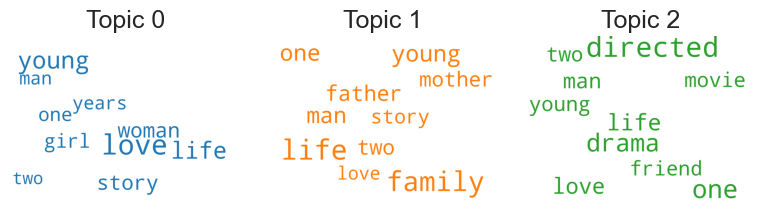

In [16]:
text_data = get_movie_plots(df, 'Drama', 'during')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()

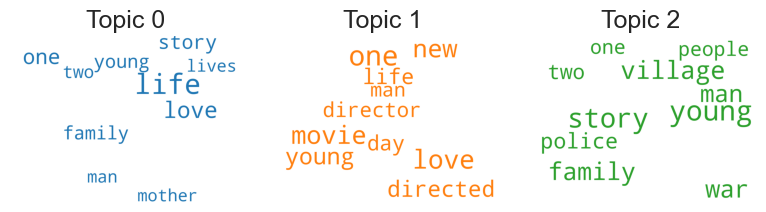

In [17]:
text_data = get_movie_plots(df, 'Drama', 'post')
model = LDAModel(text_data, 3)
model.train()
model.plot_topics()